In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import transformers
import json
from pathlib import Path
import torch
from transformers import BertForQuestionAnswering
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm.auto import tqdm
print("pakages imported")

pakages imported


MyBertSelfAttention_detect

In [3]:
BATCH_SIZE = 1
from torch import nn
GRAPH =[]
from torch.nn import Softmax
class MyBertSelfAttention_detect(nn.Module):
    def __init__(self, config):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(config, "embedding_size"):
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads)
            )

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)
        self.config = config
        
        self.perturb_on = False
        self.perturb = None
        self.sofm = Softmax(dim = 0)
        
        self.flag = False
        self.count = 0
#         self.hidden_temp = None

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
        self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")
        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            self.max_position_embeddings = config.max_position_embeddings
            self.distance_embedding = nn.Embedding(2 * config.max_position_embeddings - 1, self.attention_head_size)

        self.is_decoder = config.is_decoder
    #modified
    
    def p_init(self, input_length, start_from = None):
        SQRT_NUMEL = (input_length * self.config.hidden_size) ** 0.5
        self.perturb = torch.zeros((BATCH_SIZE, input_length, self.config.hidden_size), device = torch.device('cuda')).uniform_(-INIT_MAG, INIT_MAG)/SQRT_NUMEL
        
        self.perturb[:, 0, : ] = 0.0
        self.perturb[:, -1, :] = 0.0
        
        if start_from is not None:
            self.perturb = (self.perturb + start_from).detach()
            
        self.perturb.requires_grad_()
        
    def p_accu(self, loss, adv_lr, input_length = 5):
        grad = torch.autograd.grad(loss, self.perturb)[0]

        grad[:, 0, :] = 0.0
        grad[:, -1, :] = 0.0
        
        grad = (adv_lr * grad/grad.norm()).detach()
        
        self.perturb = (self.perturb + grad).detach()

        self.perturb.grad = None
        self.perturb.requires_grad_()
        
    ##here
    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        if self.perturb is not None:
            hidden_states = hidden_states + self.perturb
        
        mixed_query_layer = self.query(hidden_states)
        
        
        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention and past_key_value is not None:
            # reuse k,v, cross_attentions
            key_layer = past_key_value[0]
            value_layer = past_key_value[1]
            attention_mask = encoder_attention_mask
        elif is_cross_attention:
            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
        elif past_key_value is not None:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))
            key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
            value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
        else:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))

        query_layer = self.transpose_for_scores(mixed_query_layer)

        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key_layer, value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            seq_length = hidden_states.size()[1]
            position_ids_l = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
            position_ids_r = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
            distance = position_ids_l - position_ids_r
            positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
            positional_embedding = positional_embedding.to(dtype=query_layer.dtype)  # fp16 compatibility

            if self.position_embedding_type == "relative_key":
                relative_position_scores = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores
            elif self.position_embedding_type == "relative_key_query":
                relative_position_scores_query = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                relative_position_scores_key = torch.einsum("bhrd,lrd->bhlr", key_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores_query + relative_position_scores_key

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
            
        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        #modified

        attention_probs = nn.Softmax(dim=-1)(attention_scores)


        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        if self.is_decoder:
            outputs = outputs + (past_key_value,)
        return outputs

In [4]:
GLUE_TASKS = ["cola", "mnli", "mnli-mm", "mrpc", "qnli", "qqp", "rte", "sst2", "stsb", "wnli"]
task = "imdb"
model_checkpoint = "roberta-base"
model_state = None

In [5]:
from datasets import load_dataset, load_metric
import datasets

from transformers import RobertaForSequenceClassification
import math

from datasets import load_dataset, load_metric
import datasets
actual_task = "mnli" if task == "mnli-mm" else task
dataset = datasets.DatasetDict.load_from_disk("glue/" + actual_task) if task != "imdb" else datasets.load_from_disk('imdb')

if task == "imdb":
    del dataset['unsupervised']

from transformers import AutoTokenizer, AutoModelForMaskedLM, RobertaForSequenceClassification

tokenizer = torch.load("robertatokenizer.tkz")

task_to_keys = {  
            "sst2": ("sentence", None),
            "imdb": ("text", None)
        }

sentence1_key, sentence2_key = task_to_keys[task]

def preprocess_function(examples):
    if sentence2_key is None:
        return tokenizer(examples[sentence1_key], truncation=True)
    return tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True)

encoded_dataset = dataset.map(preprocess_function, batched=True)
encoded_dataset.set_format("numpy")

In [6]:
# model = RobertaForSequenceClassification.from_pretrained(model_checkpoint, num_labels = num_labels, mirror = "bfsu")
# torch.save(model.state_dict(),"raw_pretrained_state.pth")

model = torch.load('IMDB-robertabase-fullunit-8848.pt')
# model.load_state_dict(torch.load("SST2-fullfintuned-robertabase-8848.pth"))
torch.save(model.state_dict(),"temp_state.pth")

for i in model.roberta.encoder.layer:
    p_layer = MyBertSelfAttention_detect(model.config)
    i.attention.self = p_layer

model.load_state_dict(torch.load('temp_state.pth'))
torch.cuda.empty_cache()
if torch.cuda.is_available():
    model.cuda()

In [7]:
from transformers import AutoModelForMaskedLM
mlm_model = AutoModelForMaskedLM.from_pretrained('roberta-base', mirror = "bfsu")
probe_layer = mlm_model.lm_head
probe_layer.cuda()

RobertaLMHead(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (decoder): Linear(in_features=768, out_features=50265, bias=True)
)

In [8]:
# victim_model = RobertaForSequenceClassification(model.config)

# victim_model.load_state_dict(torch.load("SST2-fullfintuned-robertabase-8848.pth"))
victim_model = torch.load('IMDB-robertabase-fullunit-8848.pt')
if torch.cuda.is_available():
    victim_model.cuda()

In [9]:
import tensorflow_hub as hub
import tensorflow as tf
class USE:
    def __init__(self):
        self.embed = hub.load("use")

    def count_use(self, sentence1, sentence2):
        embeddings = self.embed([sentence1, sentence2])

        vector1 = tf.reshape(embeddings[0], [512, 1])
        vector2 = tf.reshape(embeddings[1], [512, 1])

        return tf.matmul(vector1, vector2, transpose_a=True).numpy()[0][0]
use = USE()

In [10]:
from torch.nn import CrossEntropyLoss, MSELoss
class Prober():
    
    def __init__(self, tokenizer, probe_layer, victim_model):
        self.celoss = CrossEntropyLoss()
        self.tokenizer = tokenizer
        self.probe_layer = probe_layer
        self.victim = victim_model
        
        if torch.cuda.is_available():
            self.probe_layer.cuda()
            
    def decode(self, hidden, origin_ids = None):
        probe = self.probe_layer(hidden)
        
        _probe = probe.detach()
        _probe[:, :,0:4] = 0.0
        #mask token
        _probe[:, :,50264] = 0.0
        
        
        reconstruction_ids = torch.topk(_probe, 1, -1)[1].squeeze(-1)
        
        reconstruction_ids[:, 0] = 1
        reconstruction_ids[:,-1] = 2
        
        if origin_ids is None:
            return reconstruction_ids
        
        origin_ids = origin_ids[:, 1:-1].long().cuda()
        probe = probe[:, 1:-1, :]

        
        decode_loss = self.celoss(probe.reshape(-1, tokenizer.vocab_size), origin_ids.reshape(-1))

        return decode_loss, reconstruction_ids
        
    
    def attack(self, ids, answer_label):
        
        ids = ids.unsqueeze(0).cuda()
        attention_mask = (torch.zeros(ids.shape) + 1).long().cuda()
        
        output = self.victim(input_ids = ids, attention_mask = attention_mask, labels = answer_label)
        logits = output[1]

        adv_answer = logits.argmax(dim = 1)
        
        ids = ids[:, 1:-1]
        reconstruction_tokens = self.tokenizer.batch_decode(ids)
        reconstruction_sentence = self.tokenizer.convert_tokens_to_string(reconstruction_tokens)
#         print(reconstruction_sentence)

#         print(adv_answer,answer_label, "LOGITS: ", logits )
        reconstruction_sentence = None
        
        
        if not adv_answer.equal(answer_label):
            #print("CALL")
            reconstruction_tokens = self.tokenizer.batch_decode(ids)
            reconstruction_sentence = self.tokenizer.convert_tokens_to_string(reconstruction_tokens)
            
        return reconstruction_sentence
    
prober = Prober(tokenizer, probe_layer, victim_model)

In [11]:
from tqdm import tqdm

def cal_metric(s1, s2):
    _use = use.count_use(s1,s2)
    return _use,0,0

def attack_step(dataset = None, encoded_dataset = None, index = 0, 
                adv_lr = 3e-2, adv_steps = 3, start_layer = 0, prober = None, 
                scheduler = None, SEED = 114514):
    
    encoded_dataset.set_format("numpy")
    
    def model_forward(model, input_ids, attention_mask, labels):
        output = model(input_ids=input_ids, attention_mask=attention_mask, labels = labels, output_hidden_states = True)
        loss = output[0]
        hidden = output[2][HIDDEN_INDEX]
        logits = output[1]
        return loss,logits,hidden
    
    def random_cover(ids):
        import random 
        rindex = random.randint(1, input_length- 2)
        ids[:, rindex] = 50264
        return ids
    
    

    ori_sentence = dataset[KEY][index]['text']
    input_ids = torch.tensor(encoded_dataset[KEY]['input_ids'][index]).unsqueeze(0)
    attention_mask = torch.tensor(encoded_dataset[KEY]['attention_mask'][index]).unsqueeze(0)
    label = torch.tensor(encoded_dataset[KEY]['label'][index]).unsqueeze(0).cuda()
    
    #print("LABEL", label)
    correct_test = prober.attack(input_ids[0], label)
    #print(correct_test)
    if correct_test is not None:
        return None
    
    #BATCH SET UP
    input_length = len(input_ids[0])
    ori_input_ids = torch.tensor(input_ids.tolist() * BATCH_SIZE).cuda()
    attention_mask = torch.tensor(attention_mask.tolist() * BATCH_SIZE).cuda()
    batch_labels = torch.tensor(label.tolist() * BATCH_SIZE).cuda()
    
    input_ids = random_cover(ori_input_ids.clone())
    
    p_layer = model.roberta.encoder.layer[start_layer].attention.self
    p_layer.perturb = None
        
    
    successed = False
    query = 0
    pll = 0
    I = 0
    use = 0
    bpstep = 0
    rec_token_acc = 0
    adv_sentence = None
    
    id_base = []
    id_base.append(input_ids.tolist())

    torch.manual_seed(SEED)
    origin_loss, origin_logits, origin_hidden = model_forward(model, input_ids=input_ids, attention_mask=attention_mask, labels = batch_labels)
    reconstruct_ids = prober.decode(origin_hidden)

    rec_token_acc = ((input_ids == reconstruct_ids).sum() / input_ids.numel()).tolist()
    
    for i in reconstruct_ids:
        if not i.tolist() in id_base:
            id_base.append(i.tolist())
            query += 1
            adv_sentence = prober.attack(i, label)
            if adv_sentence is not None:
                use,I,ppl = cal_metric(ori_sentence, adv_sentence)
                #print("USE = ", use)
                if use > USE_GATE:
                    successed = True
                    bpstep = -1
                    successed = True
                    return{
                        'successed': successed,
                        'query': query,
                        'pll': pll,
                        'I': I,
                        'use': use,
                        'bpstep': bpstep,
                        'token_acc': rec_token_acc,
                        'ori_sentence': ori_sentence,
                        'adv_sentence': adv_sentence
                    }

    torch.manual_seed(SEED)
    p_layer.p_init(input_length)
    torch.manual_seed(SEED)
    loss, logits, hidden = model_forward(model, input_ids=input_ids, attention_mask=attention_mask, labels = batch_labels)
    decode_loss, init_ids = prober.decode(hidden, origin_ids = input_ids)
    
    for i in init_ids:
        if not i.tolist() in id_base:
            id_base.append(i.tolist())
            query += 1
            adv_sentence = prober.attack(i, label)
            if adv_sentence is not None:
                use,I,ppl = cal_metric(ori_sentence, adv_sentence)
                if use > USE_GATE:
                    successed = True
                    bpstep = -1
                    successed = True
                    return{
                        'successed': successed,
                        'query': query,
                        'pll': pll,
                        'I': I,
                        'use': use,
                        'bpstep': bpstep,
                        'token_acc': rec_token_acc,
                        'ori_sentence': ori_sentence,
                        'adv_sentence': adv_sentence
                    }



    seg_step = 0
    max_use = 0
    
    for seg_step in range(SEG_STEP):
        lr = adv_lr
        for i in (range(adv_steps)):

            projected = p_layer.p_accu(loss * LOSS_WEIGHT - decode_loss * DECODE_WEIGHT, lr, input_length = input_length)

            torch.manual_seed(SEED)
            loss, logits, hidden =  model_forward(model, input_ids=input_ids, attention_mask=attention_mask, labels = batch_labels)
            decode_loss, p_ids = prober.decode(hidden, origin_ids = input_ids)

            for p_id in p_ids:
                if not p_id.tolist() in id_base:
                    id_base.append(p_id.tolist())
                    query += 1
                    adv_sentence = prober.attack(p_id, label)

                    if adv_sentence is not None:
                        use,I,ppl = cal_metric(ori_sentence, adv_sentence)
#                         print(adv_sentence, " USE = ", use)
                        if use> max_use:
                            max_use = use
                        if use > USE_GATE:
                            successed = True
                            bpstep = seg_step * adv_steps + i
                            successed = True
                            return{
                                'successed': successed,
                                'query': query,
                                'pll': pll,
                                'I': I,
                                'use': use,
                                'bpstep': bpstep,
                                'token_acc': rec_token_acc,
                                'ori_sentence': ori_sentence,
                                'adv_sentence': adv_sentence
                            }
#         print("################RESET!####################", " D_LOSS = ", (loss-origin_loss).norm(), "BASED: ", len(id_base), "Query; ", query)
        input_ids = random_cover(ori_input_ids.clone())
#         print(input_ids.tolist())
        torch.manual_seed(SEED + seg_step)
        p_layer.p_init(input_length, start_from = None)
        loss, logits, hidden = model_forward(model, input_ids=input_ids, attention_mask=attention_mask, labels = batch_labels)
    torch.cuda.empty_cache()
    return{
        'successed': successed,
        'query': query,
        'pll': pll,
        'I': I,
        'use': max_use,
        'bpstep': bpstep,
        'token_acc': rec_token_acc,
        'ori_sentence': ori_sentence,
        'adv_sentence': adv_sentence
    }


In [12]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [13]:
model.cuda()
import seaborn as sb
import gc

KEY = 'test'

gc.collect()
torch.cuda.empty_cache()
SEG_STEP = 5

HIDDEN_INDEX = 8
INIT_MAG = 1

BATCH_SIZE = 1
USE_GATE = 0.92

SEED = 114514


LOSS_WEIGHT = 1
DECODE_WEIGHT = 0.01

suca = []
alla = []
import random
random.seed(SEED)
for i in tqdm(range(677, 1000)):
    gc.collect()
    torch.cuda.empty_cache()
    ret = attack_step(
        dataset = dataset, 
        encoded_dataset = encoded_dataset, 
        index = i, 
        adv_lr = 5,
        adv_steps = 200, 
        start_layer = 0, 
        prober = prober,
        scheduler = None,
        SEED = SEED
        )
#     print(ret)
    if ret is not None:
        if ret['successed']:
            suca.append(ret)
        alla.append(ret)

  0%|          | 0/323 [00:00<?, ?it/s]/mistgpu/site-packages/datasets/formatting/formatting.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(array, copy=False, **self.np_array_kwargs)
100%|██████████| 323/323 [2:02:09<00:00, 22.69s/it]  


In [14]:
torch.save(alla, "alla_677_1000.pt")

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


{'successed': 0.678343949044586, 'query': 473.00955414012736, 'pll': 0.0, 'I': 0.0, 'use': 0.91511443674944, 'bpstep': 149.5796178343949, 'token_acc': 0.6760560395611319}


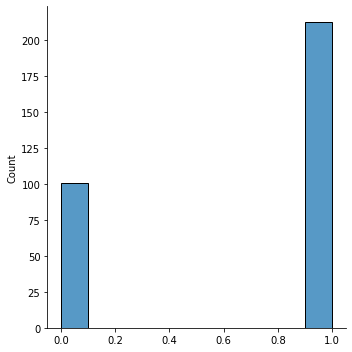

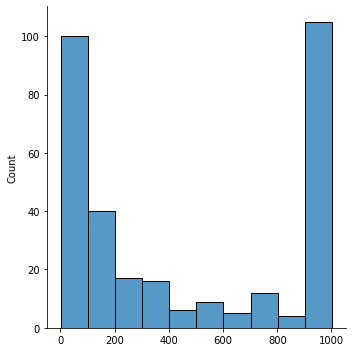

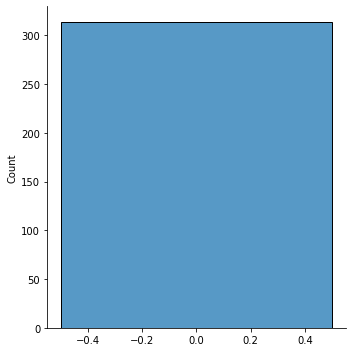

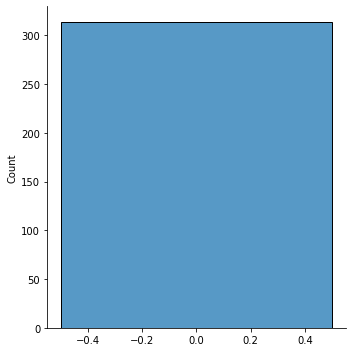

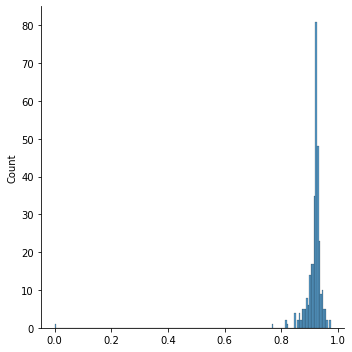

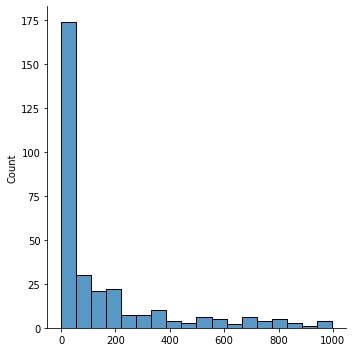

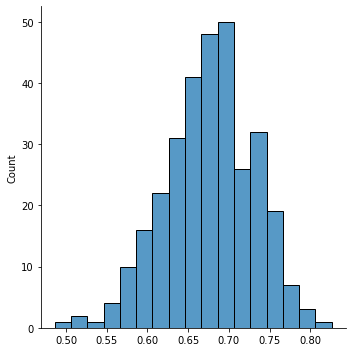

In [15]:

import seaborn as sb
stat = {
        'successed': [],
        'query': [],
        'pll': [],
        'I': [],
        'use': [],
        'bpstep': [],
        'token_acc': [],
    }
for key in stat.keys():
    for data in alla:
        stat[key].append(data[key])
    sb.displot(stat[key])
    if key != 'successed':
        stat[key] = np.array(stat[key]).mean()
    else:
        stat[key] = len(suca)/len(alla)
print(stat)

In [16]:
u = []
bar = 5
alla = torch.load('alla_403_676.pt')
for data in alla:
    u.append(data['use'])
u.sort()
u = np.array(u)
print(u[bar:].mean())
print(len(u[bar:]) / len(u))

0.90951656985017
0.9817518248175182


In [17]:
print(u)

[0.         0.         0.74820983 0.78343046 0.78452742 0.79414821
 0.79855031 0.8165372  0.8197341  0.82699096 0.82936323 0.83067167
 0.83278638 0.83982301 0.8407557  0.84287769 0.84940434 0.84996676
 0.85233825 0.85252428 0.85294521 0.8555131  0.85584348 0.85846615
 0.85904759 0.86024874 0.86065745 0.86111522 0.86131573 0.86161333
 0.86178565 0.86242938 0.86307156 0.86455083 0.86720538 0.8692168
 0.86929774 0.86937231 0.87005228 0.87112391 0.87191296 0.87295347
 0.87933755 0.8800754  0.88157159 0.88218856 0.88266313 0.88299131
 0.88309753 0.88327569 0.88420892 0.8846302  0.88585925 0.88846272
 0.8889221  0.88941681 0.88978314 0.89002246 0.8901931  0.89067727
 0.89132738 0.89210892 0.893089   0.89309472 0.89372349 0.89375186
 0.89439678 0.89562297 0.89610803 0.89661419 0.89845121 0.89958364
 0.89999408 0.90005893 0.90028483 0.90080506 0.90113306 0.90140545
 0.90176284 0.90177107 0.90214419 0.90255481 0.90292692 0.90297419
 0.9031409  0.90332568 0.90431046 0.90493441 0.90539861 0.90669

In [18]:
len(suca)/len(alla)

0.7773722627737226

In [19]:
for data in alla:
    if data['use'] > 0.85:
        print(data)

{'successed': True, 'query': 145, 'pll': 0, 'I': 0, 'use': 0.9216961, 'bpstep': 143, 'token_acc': 0.7054545283317566, 'ori_sentence': 'I actually flipped to Lifetime channel by mistake, just as this movie was beginning, and ended-up watching it. <br /><br />It certainly deals with a serious issue, probably more prevalent than we realize, in terms of this type of attack of a young woman by an ego-maniacal fellow-student, who feels he\'s above the system, and, unfortunately, often is.<br /><br />The cast here was believable, and the performances credible. A lot of these Canadian/Lifetime flicks are decidedly "over-the-top." However, this is one I might label as "under-the-top."<br /><br />While appreciating the fact that it wasn\'t presented in an overblown fashion, this film somehow seemed like a record being played at a slower speed than proper, the 96 minutes seemed like many more, and it had the effect of looking like a shorter film, looped over-and-over, seemingly going on and on an

In [20]:
len(alla)

274

In [21]:
100/102

0.9803921568627451